In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Flatten,Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 类别数
num_classes = 17
# 批次大小
batch_size = 32
# 周期数
epochs = 40
# 图片大小
image_size = 224

In [3]:
# 训练集数据进行数据增强
train_datagen = ImageDataGenerator(
    rotation_range = 20,     # 随机旋转度数
    width_shift_range = 0.1, # 随机水平平移
    height_shift_range = 0.1,# 随机竖直平移
    rescale = 1/255,         # 数据归一化
    shear_range = 10,       # 随机错切变换
    zoom_range = 0.1,        # 随机放大
    horizontal_flip = True,  # 水平翻转
    brightness_range=(0.7, 1.3), # 亮度变化
    fill_mode = 'nearest',   # 填充方式
) 
# 测试集数据只需要归一化就可以
test_datagen = ImageDataGenerator(
    rescale = 1/255,         # 数据归一化
) 

In [4]:
# 训练集数据生成器，可以在训练时自动产生数据进行训练
# 从'data/train'获得训练集数据
# 获得数据后会把图片resize为image_size×image_size的大小
# generator每次会产生batch_size个数据
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    )

# 测试集数据生成器
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    )

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [5]:
# 字典的键为17个文件夹的名字，值为对应的分类编号
label = train_generator.class_indices
# 把字典的键值对反过来
# 分类编号为键，分类名称为值
label = dict(zip(label.values(),label.keys()))
# 保存到json文件中
file = open('label_flower.json','w',encoding='utf-8')
json.dump(label, file)

In [6]:
# 载入使用imagenet训练好的预训练模型
# include_top=True表示模型包含全连接层
# include_top=False表示模型不包含全连接层
vgg16 = VGG16(weights='imagenet',include_top=False, input_shape=(image_size,image_size,3))

In [7]:
# 搭建全连接层，连接在VGG16模型后面
# 我们主要是利用VGG16卷积网络已经训练好的特征提取能力来提取特征
# 然后搭建新的全连接层来进行新图片类型的分类
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256,activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes,activation='softmax'))

model = Sequential()
model.add(vgg16)
model.add(top_model)

In [8]:
# 定义优化器，代价函数，训练过程中计算准确率，设置一个较小的学习率
model.compile(optimizer=SGD(lr=1e-3,momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

# Tensorflow2.1版本之前可以使用fit_generator训练模型
# history = model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=epochs,validation_data=test_generator,validation_steps=len(test_generator))

# Tensorflow2.1版本(包括2.1)之后可以直接使用fit训练模型
history = model.fit(x=train_generator,epochs=epochs,validation_data=test_generator)

W0320 17:33:53.960256 16672 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0320 17:33:54.116810 16672 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 34 steps, validate for 9 steps
Epoch 1/40
34/34 [==============================] - 15s 440ms/step - loss: 2.8396 - accuracy: 0.1131 - val_loss: 2.2644 - val_accuracy: 0.2904
Epoch 2/40
34/34 [==============================] - 14s 406ms/step - loss: 1.9765 - accuracy: 0.3713 - val_loss: 1.3263 - val_accuracy: 0.6029
Epoch 3/40
34/34 [==============================] - 14s 406ms/step - loss: 1.4046 - accuracy: 0.5671 - val_loss: 0.9596 - val_accuracy: 0.6838
Epoch 4/40
34/34 [==============================] - 14s 406ms/step - loss: 0.9382 - accuracy: 0.7096 - val_loss: 0.4878 - val_accuracy: 0.8566
Epoch 5/40
34/34 [==============================] - 14s 403ms/step - loss: 0.7819 - accuracy: 0.7739 - val_loss: 0.7629 - val_accuracy: 0.7794
Epoch 6/40
34/34 [==============================] - 14s 404ms/step - loss: 0.5544 - accuracy: 0.8373 - val_loss: 0.3264 - val_accuracy: 0.8713
Epoch 7/40
34/34 [==============================] - 14s 398ms/step - loss: 0.5287 - accuracy: 0.8318 

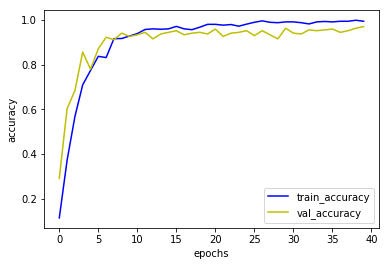

In [15]:
# 画出训练集准确率曲线图
plt.plot(np.arange(epochs),history.history['accuracy'],c='b',label='train_accuracy')
# 画出验证集准确率曲线图
plt.plot(np.arange(epochs),history.history['val_accuracy'],c='y',label='val_accuracy')
# 图例
plt.legend()
# x坐标描述
plt.xlabel('epochs')
# y坐标描述
plt.ylabel('accuracy')
# 显示图像
plt.show()
# 模型保存
model.save('vgg16.h5')